In [1]:
import subprocess
import time
import re
import psutil
from torch.profiler import profile, ProfilerActivity
from cubes import get_cube
import matplotlib.pyplot as plt

In [2]:
def profile_and_capture(cmd):
    # Start process
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, text=True)
    ps_proc = psutil.Process(proc.pid)

    parent_mem_records = []

    # Monitoring Loop
    while proc.poll() is None:
        try:
            abs_now = time.time()
            mem = ps_proc.memory_info().rss / (1024 * 1024)
            for child in ps_proc.children(recursive=True):
                mem += child.memory_info().rss / (1024 * 1024)
            parent_mem_records.append((abs_now, mem))
        except psutil.NoSuchProcess:
            break
        time.sleep(0.05)

    # Capture all output after process ends
    stdout_data, _ = proc.communicate()

    # Parse timestamps using Regex
    internal_events = re.findall(r"(\w+):(\d+\.\d+)", stdout_data)
    internal_events = {tag: float(ts) for tag, ts in internal_events}

    return parent_mem_records, internal_events

In [3]:
device = "cpu"
order = "1"
interval = 0.05
results = {}
timings = {}

print("|  N  |     DOFs |     Setup | FWD Solve | BWD Solve |   Peak RAM |")
print("| --- | -------- | --------- | --------- | --------- | ---------- |")

for N in [10, 20, 30, 40, 50, 60, 70, 80]:
    cmd = ["python", "cubes.py", "-N", str(N), "-device", device, "-order", order]
    mem_data, internal_clock = profile_and_capture(cmd)
    mem_usage = [m for _, m in mem_data]
    setup_t = internal_clock["SETUP_DONE"] - internal_clock["START"]
    fwd_t = internal_clock["FWD_DONE"] - internal_clock["SETUP_DONE"]
    bwd_t = internal_clock["BWD_DONE"] - internal_clock["FWD_DONE"]
    print(
        f"| {N:3d} | {3*N**3:8d} | {setup_t:8.2f}s | {fwd_t:8.2f}s | {bwd_t:8.2f}s "
        f"| {max(mem_usage):8.1f}MB |"
    )
    results[N] = (mem_data, internal_clock)

|  N  |     DOFs |     Setup | FWD Solve | BWD Solve |   Peak RAM |
| --- | -------- | --------- | --------- | --------- | ---------- |
|  10 |     3000 |     0.02s |     0.18s |     0.14s |    448.2MB |
|  20 |    24000 |     0.15s |     0.78s |     0.21s |    847.1MB |
|  30 |    81000 |     0.56s |     2.86s |     0.67s |   1979.2MB |
|  40 |   192000 |     1.31s |     6.94s |     1.17s |   2988.7MB |
|  50 |   375000 |     2.69s |    15.36s |     2.59s |   4011.4MB |
|  60 |   648000 |     5.31s |    26.63s |     4.06s |   5760.9MB |
|  70 |  1029000 |     8.93s |    45.27s |     6.81s |   7885.4MB |
|  80 |  1536000 |    14.28s |    81.66s |    12.60s |   9360.8MB |


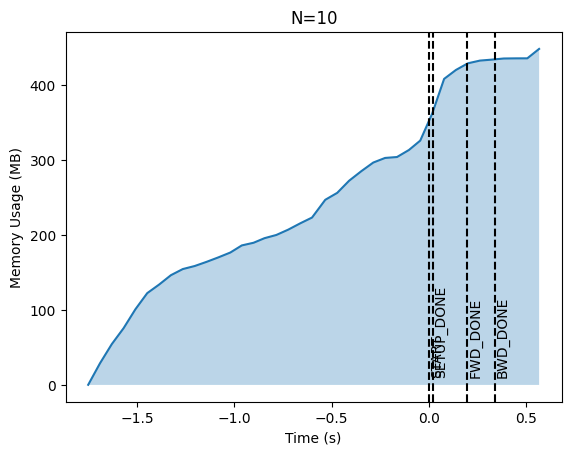

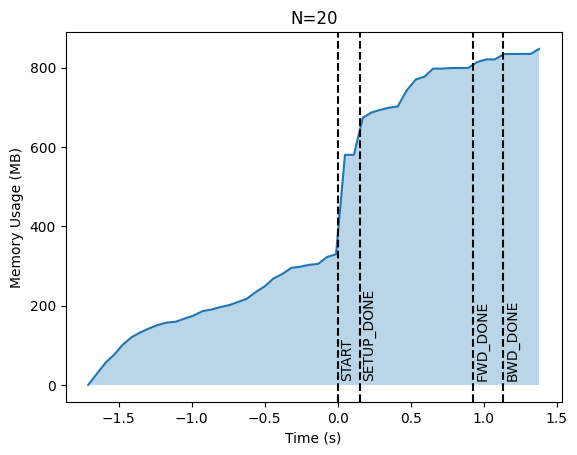

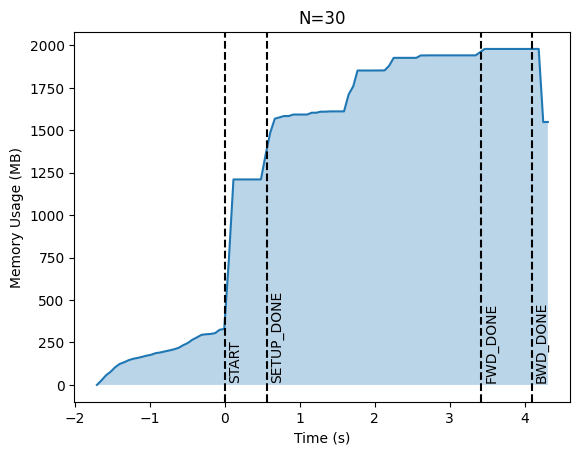

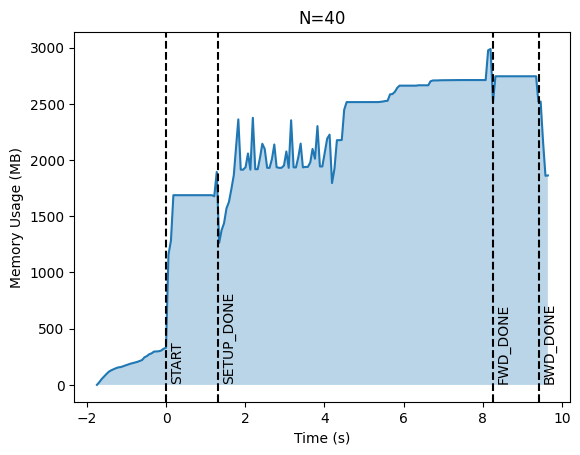

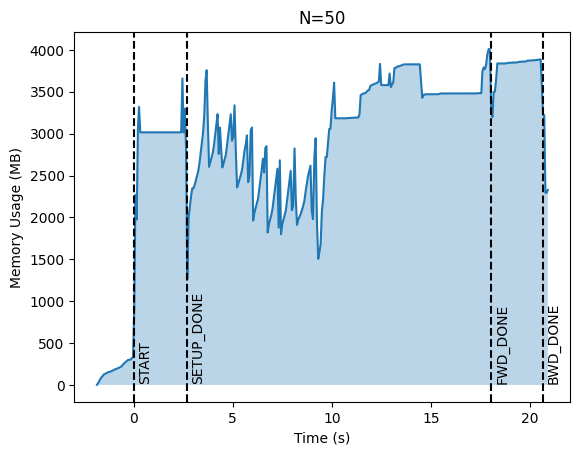

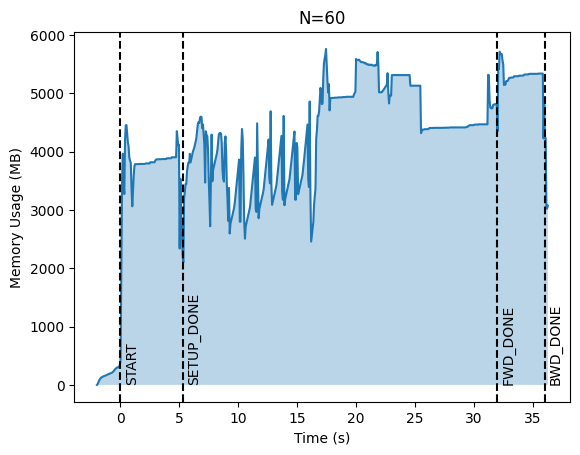

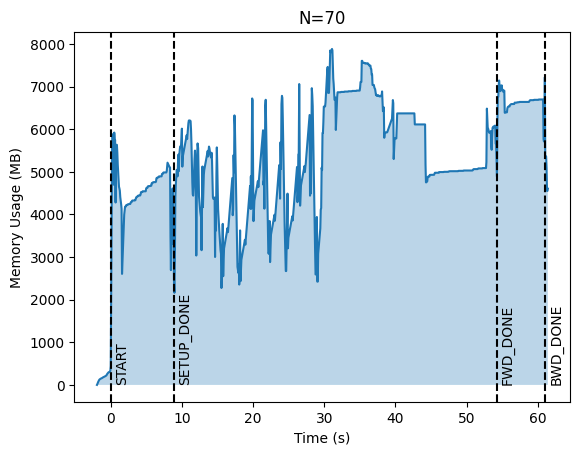

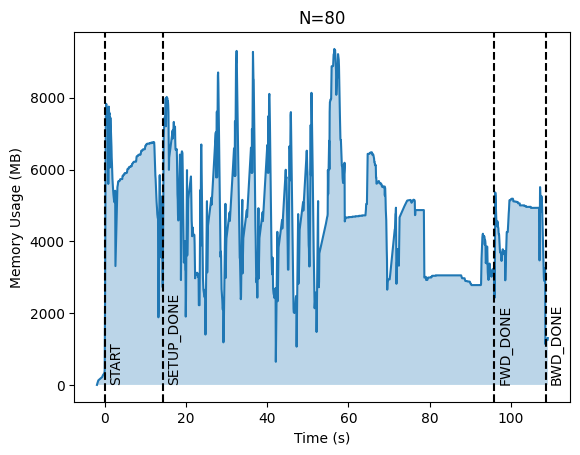

In [4]:
for N, (mem_data, internal_clock) in results.items():
    t0 = internal_clock["START"]
    times = [t - t0 for t, _ in mem_data]
    mem_usage = [m for _, m in mem_data]
    plt.plot(times, mem_usage)
    plt.fill_between(times, mem_usage, alpha=0.3)
    for tag, abs_ts in internal_clock.items():
        relative_ts = abs_ts - t0
        plt.axvline(x=relative_ts, color="black", linestyle="--")
        plt.text(
            relative_ts + 0.01 * max(times),
            10,
            tag,
            rotation=90,
            verticalalignment="bottom",
        )
    plt.xlabel("Time (s)")
    plt.ylabel("Memory Usage (MB)")
    plt.title(f"N={N}")
    plt.show()

In [5]:
import cProfile
import pstats


def test():
    cube = get_cube(50)
    cube.solve()


cProfile.run("test()", "stats")
p = pstats.Stats("stats")
print(p.sort_stats("time").print_stats(10))

Tue Feb  3 13:01:26 2026    stats

         29360 function calls (29096 primitive calls) in 17.484 seconds

   Ordered by: internal time
   List reduced from 540 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       62    5.318    0.086    5.318    0.086 {built-in method torch.einsum}
       96    2.353    0.025    2.353    0.025 {built-in method pyamg.amg_core.relaxation.gauss_seidel}
        1    2.271    2.271    2.271    2.271 {built-in method torch._unique2}
       77    1.704    0.022    1.704    0.022 {built-in method scipy.sparse._sparsetools.csr_matvec}
        8    1.474    0.184    1.474    0.184 {built-in method scipy.sparse._sparsetools.bsr_matmat}
        2    0.687    0.343    6.652    3.326 /Users/meyernil/Code/torch-fem/src/torchfem/base.py:457(integrate_material)
      141    0.508    0.004    0.508    0.004 {built-in method scipy.sparse._sparsetools.bsr_matvec}
       30    0.280    0.009    0.280    0.009 {meth

In [6]:
with profile(
    activities=[ProfilerActivity.CPU],
    profile_memory=True,
    record_shapes=True,
) as prof:
    cube = get_cube(20)
    solution = cube.solve()


# Export trace to Chrome Trace format (this can be opened in chrome://tracing or https://ui.perfetto.dev/)
prof.export_chrome_trace("trace.json")
# Print profiler results
print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      aten::einsum         0.33%       4.438ms        49.93%     676.242ms      10.907ms     561.87 Mb    -153.64 Mb            62  
                                         aten::mul         1.46%      19.837ms         1.48%      20.031ms      90.230us     540.38 Mb     539.12 Mb           222  
                                       aten::empty         0.02%     234.457us         0.02%     234.457us       1.817us     481.31 Mb     481.31 Mb           129  
          